In [1]:
# the langchain related imports
from typing import Any, List, Mapping, Optional

from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM

# if you need the agent from langchain
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType

# if you need the Conversation from langchain
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [2]:
import os
import cv2
import llama
import torch
from PIL import Image

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from llama.llama_adapter import  LLaMA_adapter
from torchvision.transforms.transforms import Compose
from PIL import Image

In [3]:
class LLaMALangChain(LLM):

    generator: LLaMA_adapter
    preprocess: Compose
    device: str = "cuda"
    temperature: float = 0.1
    top_p: float = 0.75
    max_seq_len: int = 512
    max_gen_len: int = 64

    @property
    def _llm_type(self) -> str:
        return "LLaMA Adapter"
    
    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
    ) -> str:
        # since the langchain currently does not support image input, we add image path inside the prompt
        image_path = prompt[:prompt.find("<ImgPathEnd>")]
        img = Image.fromarray(cv2.imread(image_path))
        img = preprocess(img).unsqueeze(0).to(device)

        prompt = prompt[prompt.find("<ImgPathEnd>")+len("<ImgPathEnd>"):]
        full_result = self.generator.generate(img, [prompt], max_gen_len=self.max_gen_len, temperature=self.temperature, top_p=self.top_p)[0]
        if "Response" in full_result:
            pure_response = full_result[full_result.rfind("Response:")+9:]
        else:
            pure_response = full_result
        # to avoid it automatically adding a self-proposed question
        if "### Input:" in pure_response:
            print(f"### Input: found in response {pure_response}, removing it")
            pure_response = pure_response[:pure_response.find("### Input:")]
            print(f"New response: {pure_response}")
        return pure_response


    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        """Get the identifying parameters."""
        return {
            "temperature": self.temperature,
            "top_p": self.top_p,
            "max_seq_len": self.max_seq_len,
        }
    

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
llama_dir = "/data1/llma"
model, preprocess = llama.load("BIAS-7B", llama_dir, device, max_seq_len=2048)

Loading LLaMA-Adapter from ckpts/7fa55208379faf2dd862565284101b0e4a2a72114d6490a95e432cf9d9b6c813_BIAS-7B.pth


In [5]:
temperature = 0.1
top_p = 0.75
max_gen_len = 256
max_seq_len = 2048
llm = LLaMALangChain(generator=model, preprocess=preprocess, 
                    temperature=temperature, top_p=top_p, max_seq_len=max_seq_len, 
                    max_gen_len=max_gen_len, device=device)

In [10]:
from langchain.prompts.prompt import PromptTemplate
from langchain.schema import HumanMessage, AIMessage
from langchain.memory import ChatMessageHistory


conversation_template = """The following is a conversation between a human and an AI. Write a response that completes the request.

Current conversation:
{history}
### Input: {input}
### Response:"""

def conversation_fromat_prompt(input, history=None):
    conversation_template = """The following is a conversation between a human and an AI. Write a response that completes the request.

    Current conversation:
    {history}
    ### Input: {input}
    ### Response:"""

    if history is not None:
        conversation_prompt = conversation_template.format_map({'input': input, "history": history})
    else:
        conversation_prompt = conversation_template.format_map({'input': input, "history": ""})

    return conversation_prompt

def get_history_string(history):
    history_str = ""
    for message in history.messages:
        if isinstance(message, AIMessage):
            history_str += "### Response: " + message.content + "\n"
        else:
            history_str += "### Input: " + message.content + "\n\n"

def conversation_user(user_message):
    history.add_user_message(user_message)
    history_str = None
    if len(history.messages) >= 2:
        history_str = get_history_string(history)
    prompt = conversation_fromat_prompt(user_message, history=history_str)
    prompt = img_path + "<ImgPathEnd>" + prompt
    response = llm(prompt)
    history.add_ai_message(response)
    history_str = get_history_string(history)

    return response

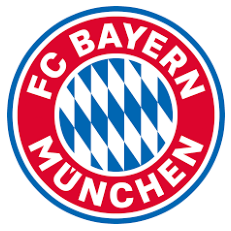

In [11]:
history = ChatMessageHistory()
img_path = "/data1/llama_adapter_project/LLaMA-Adapter-v2-Demo-release/examples/bayern_logo.png"

import matplotlib.pyplot as plt
img = plt.imread(img_path)
plt.axis('off')
plt.imshow(img)

In [12]:
user_message = "What is that Logo in the image."
conversation_user(user_message)

'The logo in the image is the FC Bayern Munich logo.'

In [13]:
user_message = "To which liga belongs this team"
conversation_user(user_message)

'Bayern Munich belongs to the German Bundesliga'

In [14]:
user_message = "Give me one of the most famous player of that team"
conversation_user(user_message)

'The most famous player of Bayern Munich is Franck Ribery.'

In [15]:
user_message = "Did this team has won many times champion?"
conversation_user(user_message)

'Yes, Bayern Munich has won many times champion.'